In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, utils
import torch.nn as nn

In [2]:
#%% Defining the processor device:
device = torch.device('cpu')

In [3]:
#%% Hyper-parameters:
num_epochs = 3
num_classes = 40
learning_rate = 0.0001
batch_size=8
test_batch=4

0 torch.Size([8, 3, 112, 92])
1 torch.Size([8, 3, 112, 92])
2 torch.Size([8, 3, 112, 92])
3 torch.Size([8, 3, 112, 92])


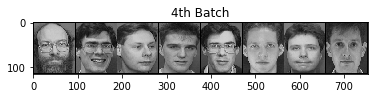

Labels: [30 12 33 23 12  0 15 16]


In [4]:
#%% Loading the data:
dataset = datasets.ImageFolder(root='data/faces/', transform=transforms.ToTensor())
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

for i, batch in enumerate(train_loader):
    print(i, batch[0].size())
    if i==3:
        grid=utils.make_grid(batch[0])
        plt.imshow(grid.numpy().transpose((1, 2, 0)))
        plt.title('4th Batch')
        plt.show()
        print('Labels:', batch[1].numpy())
        break

In [5]:
#%% Convnet Architecture:
class ConvNet(nn.Module):
    def __init__(self, num_classes=num_classes):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 12, kernel_size=3, stride=1, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(12, 12, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=5, stride=1, padding=2),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(24, 24, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(24),
            nn.ReLU())
        self.fc = nn.Linear(56 * 46 * 24, out_features=num_classes)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(-1, 56 * 46 * 24)
        out = self.fc(out)
        return out

In [6]:
#%% Calling the optimizer and Cross Entropy:
model = ConvNet(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
#%% Training the model:
model.train()
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % batch_size == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/3], Step [8/40], Loss: 4.1970
Epoch [1/3], Step [16/40], Loss: 3.4044
Epoch [1/3], Step [24/40], Loss: 1.8316
Epoch [1/3], Step [32/40], Loss: 1.3512
Epoch [1/3], Step [40/40], Loss: 0.5239
Epoch [2/3], Step [8/40], Loss: 0.0617
Epoch [2/3], Step [16/40], Loss: 0.1024
Epoch [2/3], Step [24/40], Loss: 0.0561
Epoch [2/3], Step [32/40], Loss: 0.0215
Epoch [2/3], Step [40/40], Loss: 0.0434
Epoch [3/3], Step [8/40], Loss: 0.0099
Epoch [3/3], Step [16/40], Loss: 0.0239
Epoch [3/3], Step [24/40], Loss: 0.0124
Epoch [3/3], Step [32/40], Loss: 0.0219
Epoch [3/3], Step [40/40], Loss: 0.0094


In [8]:
#%% Loading the test set:
test_set = datasets.ImageFolder(root='data/test_faces/', transform=transforms.ToTensor() )
test_loader = DataLoader(test_set, batch_size=test_batch,shuffle=True)

In [9]:
#%% Evaluating the performance of the model:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        predicted = torch.argmax(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Test accuracy of the model on the test set: {} %' .format(100*correct/total))


Test accuracy of the model on the test set: 96.25 %


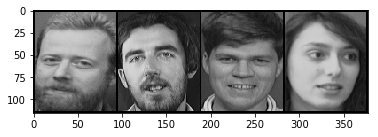

Labels: tensor([ 18,   2,  26,  38])
Predicted: tensor([ 18,   2,  26,  38])


In [10]:
#%% Showing some images and your labels and predictions:
grid=utils.make_grid(images)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()
print('Labels:', labels)
print('Predicted:', predicted)

In [11]:
#%% Show all labels and predicted labels of the test set:
model.eval()
batch=list(test_loader)
for i in range(len(test_loader)):
    image=batch[i][0]
    label=batch[i][1]
    image=image.to(device)
    label=label.to(device)
    output=model(image)
    predicted = torch.argmax(output.data, dim=1)
    print('{} P:' .format(i), predicted)
    print('{} L:' .format(i),label)

0 P: tensor([ 10,  14,   0,  10])
0 L: tensor([ 10,  14,   0,  10])
1 P: tensor([ 31,   9,  30,   1])
1 L: tensor([ 31,   9,  30,   1])
2 P: tensor([ 39,   2,  36,   4])
2 L: tensor([ 39,   2,  36,   4])
3 P: tensor([ 13,  19,  21,  16])
3 L: tensor([ 13,  19,  21,  16])
4 P: tensor([  7,  26,   7,   6])
4 L: tensor([  7,  26,   7,   6])
5 P: tensor([ 30,  35,  33,  29])
5 L: tensor([ 30,  35,  33,  29])
6 P: tensor([ 11,  19,  14,  33])
6 L: tensor([ 11,  19,  14,  33])
7 P: tensor([ 25,  20,  38,  17])
7 L: tensor([ 25,  20,  38,  17])
8 P: tensor([ 36,  18,  35,   1])
8 L: tensor([ 36,  18,  35,   1])
9 P: tensor([ 35,  23,  11,  24])
9 L: tensor([ 34,  23,  11,  24])
10 P: tensor([ 12,  20,  16,  22])
10 L: tensor([ 12,  18,  16,  22])
11 P: tensor([ 24,   5,  20,  35])
11 L: tensor([ 24,   5,  20,  34])
12 P: tensor([ 22,   6,  12,   3])
12 L: tensor([ 22,   6,  12,   3])
13 P: tensor([  4,  32,  27,   3])
13 L: tensor([  4,  32,  27,   3])
14 P: tensor([  8,   9,  21,  37])
14 L:

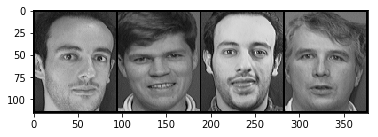

Predicted: tensor([  7,  26,   7,   6])
Label: tensor([  7,  26,   7,   6])


In [12]:
#%% Show a batch:
image=batch[4][0]
label=batch[4][1]
grid=utils.make_grid(image)
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.show()
output=model(image)
predicted = torch.argmax(output.data,dim=1)
print('Predicted:', predicted)
print('Label:',label)

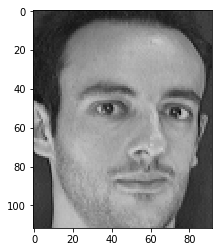

Predicted: tensor(7)
Label: tensor(7)


In [13]:
#%% Show an unique image:
model.eval()
test_image=image[0]
test_image=test_image.unsqueeze(0)
test_label=label[0]
output=model(test_image)
predicted = torch.argmax(output)
grid=utils.make_grid(test_image)
plt.imshow(grid.numpy().transpose((1,2,0)))
plt.show()
print("Predicted:",predicted)
print("Label:",test_label)

In [14]:
#%% Showing the indexes:
dataset.class_to_idx

{'s1': 0,
 's10': 1,
 's11': 2,
 's12': 3,
 's13': 4,
 's14': 5,
 's15': 6,
 's16': 7,
 's17': 8,
 's18': 9,
 's19': 10,
 's2': 11,
 's20': 12,
 's21': 13,
 's22': 14,
 's23': 15,
 's24': 16,
 's25': 17,
 's26': 18,
 's27': 19,
 's28': 20,
 's29': 21,
 's3': 22,
 's30': 23,
 's31': 24,
 's32': 25,
 's33': 26,
 's34': 27,
 's35': 28,
 's36': 29,
 's37': 30,
 's38': 31,
 's39': 32,
 's4': 33,
 's40': 34,
 's5': 35,
 's6': 36,
 's7': 37,
 's8': 38,
 's9': 39}

In [15]:
#%% Saving the model:
torch.save(model.state_dict(), 'model.ckpt')